In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

# set head directory to datafiles
datadir = '../data_clean/'


(512, 512, 512)


Text(0.5, 1.0, 'Lagrangian Density pre re-ion')

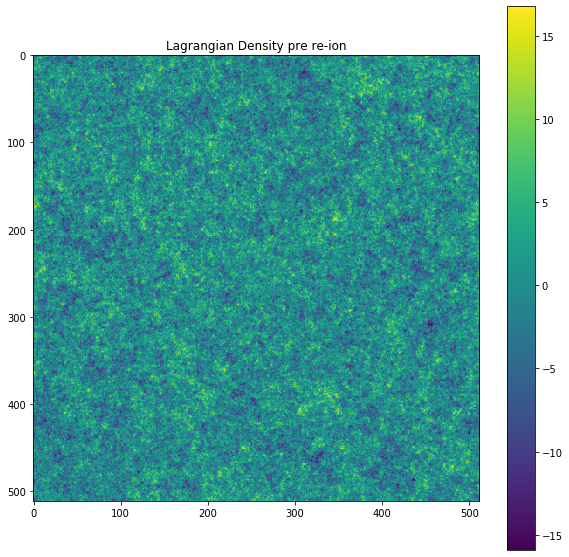

In [71]:
N = 512
# datadir = '../multiseed_runs/run0/Boxes/'

freion = open(datadir+'reionization/reion_02')
fdensL  = open(datadir+'density_Lag/dens_02')
fdensE  = open(datadir+'density_Eul/dens_02')

densL = np.fromfile(fdensL, count=N**3, dtype=np.float32).reshape(N,N,N)
densE = np.fromfile(fdensE, count=N**3, dtype=np.float32).reshape(N,N,N)
reion = np.fromfile(freion, count=N**3, dtype=np.float32).reshape(N,N,N)


print(densL.shape)
plt.figure(figsize = (10,10))
plt.imshow(densL[0])
plt.colorbar()
plt.title('Lagrangian Density pre re-ion')

In [72]:
#scaling class for use in the vision linear network to image ionization

class ScaleField(): #this is just utilizing storing the max min and average values of 
    #the strict data set!
    # used min-max scaling HERE ONLY 
    def __init__(self, field):
        super(ScaleField, self).__init__()

        self.fmin  = field.min()
        self.fmax  = field.max() 
        self.fmean = field.mean()
    
    def scale(self, field, inv=False): 
        if not inv:
            self.scaled = True
            return (field - self.fmin) / (self.fmax - self.fmin)
        if inv:
            self.scaled = False
            return field * (self.fmax - self.fmin) + self.fmin
            
density_scalingL = ScaleField(densL)
density_scalingE = ScaleField(densE)
reionization_scaling = ScaleField(reion)

densL = density_scalingL.scale(field=densL)
densE = density_scalingE.scale(field=densE)
reion = reionization_scaling.scale(field=reion)

print(densL.shape)

(512, 512, 512)


In [73]:

def cubify(arr, newshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    oldshape = np.array(arr.shape)
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.column_stack([repeats, newshape]).ravel()
    order = np.arange(len(tmpshape))
    order = np.concatenate([order[::2], order[1::2]])
    
    # newshape must divide oldshape evenly or else ValueError will be raised
    return arr.reshape(tmpshape).transpose(order).reshape(-1, *newshape)

def uncubify(arr, oldshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    N, newshape = arr.shape[0], arr.shape[1:]
    oldshape = np.array(oldshape)    
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.concatenate([repeats, newshape])
    order = np.arange(len(tmpshape)).reshape(2, -1).ravel(order='F')
    return arr.reshape(tmpshape).transpose(order).reshape(oldshape)


In [74]:


img_shape = 32

Input_shape=(img_shape,img_shape,img_shape,1)

def residual_block(x: tf.Tensor, filters: int) -> tf.Tensor:
    
    y = tfkl.Conv3D(kernel_size=(3,3,3),
               strides=(1,1,1) ,
               filters=filters,
               padding="same")(x)
    y = tfkl.BatchNormalization()(y)
    y = tfkl.ReLU()(y)
    
    y = tfkl.Conv3D(kernel_size=(3,3,3),
               strides=(1,1,1),
               filters=filters,
               padding="same")(y)
    y = tfkl.BatchNormalization()(y)
      
    y = tfkl.Add()([y, x])
    y = tfkl.ReLU()(y)
    
#     y = tf.nn.relu(tfkl.add([y, x])) 
    
    return y

def create_res_net(nlayers=2, nfilters_i=8, nfilters_increase=0):
    
    inputs       = tfkl.Input(shape=Input_shape)
    
    t = tfkl.BatchNormalization()(inputs)
    t = tfkl.Conv3D(kernel_size=(3,3,3),
               strides=(1,1,1),
               filters=nfilters_i,
               padding="same")(t)
    t = tfkl.BatchNormalization()(t)
    t = tfkl.ReLU()(t)
    
    for il in range(nlayers):
        t = residual_block(t, filters=int(nfilters_i*2**nfilters_increase))
        
    outputs = tfkl.Conv3D(filters=1,
                      kernel_size=(1,1,1),
                      strides=(1,1,1),
                      padding= 'same')(t)
    
    model = tfk.models.Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae'])

    return model


## ADD IN A RES NET FACTOR, PLAY AROUND WITH FILTERS AND KERNALS AND NUMBER
## OF LAYERS AS WELL
## LOOK UP HOW TO UPSAMPLE ONCE I DOWNSAMPLE WHICH USES STRIDES GREATER
##GREATER THAN 1
## TRY TO IMPLEMENT SOME SORT OF BAYESIAN NETWORK FACTOR INTO THIS




(4096, 32, 32, 32, 1)


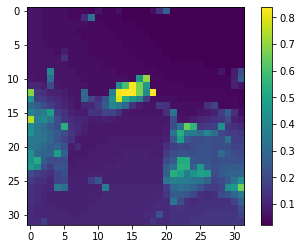

In [75]:
#training data

densL_train = cubify(densL,(img_shape,img_shape,img_shape))[..., np.newaxis]

reion_train = cubify(reion,(img_shape,img_shape,img_shape))[..., np.newaxis]

densE_train = cubify(densE,(img_shape,img_shape,img_shape))[...,np.newaxis]

print(reion_train.shape)

plt.figure()
plt.imshow(reion_train[0,0,...,0])
plt.colorbar()

In [105]:
nlayers    = 4
nfilters_i = 8

model = create_res_net(nlayers=nlayers, nfilters_i=nfilters_i) 
model.summary()
print(len(model.layers))

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 32, 32, 32,  0                                            
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 32, 32, 32, 1 4           input_14[0][0]                   
__________________________________________________________________________________________________
conv3d_58 (Conv3D)              (None, 32, 32, 32, 8 224         batch_normalization_50[0][0]     
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 32, 32, 32, 8 32          conv3d_58[0][0]                  
____________________________________________________________________________________________

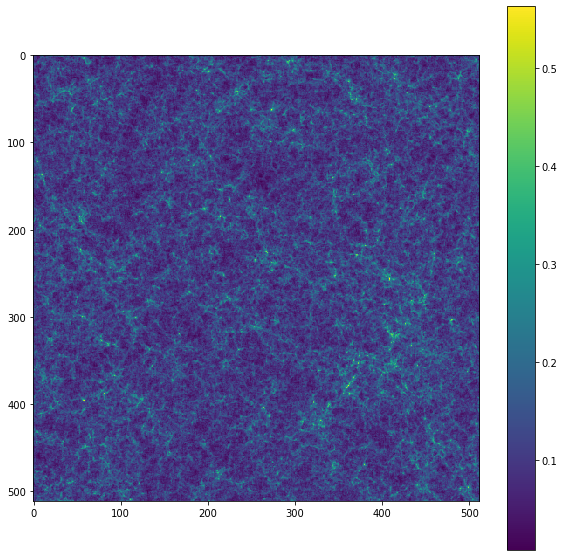

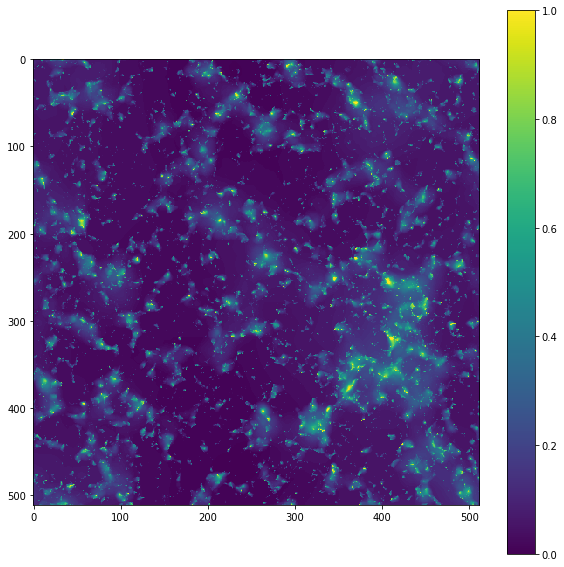

In [106]:
# get test data
freion = open(datadir+'reionization/reion_04')
fdens  = open(datadir+'density_Eul/dens_04')

x_test  = np.fromfile(fdens, count=N**3, dtype=np.float32).reshape(N,N,N)
y_test  = np.fromfile(freion, count=N**3, dtype=np.float32).reshape(N,N,N)

# density_scaling_test      = ScaleField(x_test)
# reionization_scaling_test = ScaleField(y_test)

x_test = density_scalingE.scale(field=x_test)
y_test = reionization_scaling.scale(field=y_test)


plt.figure(figsize=(10,10))
plt.imshow(x_test[0])
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(y_test[0])
plt.colorbar()

x_test = cubify(x_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]
y_test = cubify(y_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]


reion_test         = reionization_scaling.scale(field=y_test, inv=True)


In [107]:
optimizer = tfk.optimizers.Adam(1e-2)
model.compile(optimizer=optimizer,loss='mse', metrics=['mae'] )

history = model.fit(densE_train,reion_train,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/5
116/116 [==============================] - 14s 123ms/step - loss: 0.4279 - mae: 0.2919 - val_loss: 0.1307 - val_mae: 0.3290
Epoch 2/5
116/116 [==============================] - 14s 121ms/step - loss: 0.0186 - mae: 0.0982 - val_loss: 0.0213 - val_mae: 0.0972
Epoch 3/5
116/116 [==============================] - 14s 121ms/step - loss: 0.0123 - mae: 0.0796 - val_loss: 0.0256 - val_mae: 0.1112
Epoch 4/5
116/116 [==============================] - 14s 121ms/step - loss: 0.0096 - mae: 0.0697 - val_loss: 0.0165 - val_mae: 0.0840
Epoch 5/5
116/116 [==============================] - 14s 122ms/step - loss: 0.0079 - mae: 0.0629 - val_loss: 0.0092 - val_mae: 0.0628


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


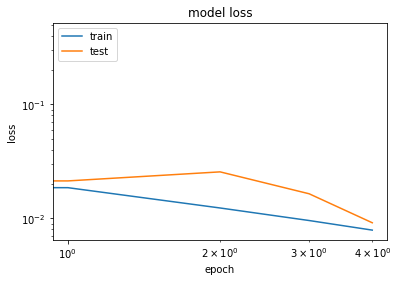

In [108]:
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.xscale('log')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
y_test_predict = model.predict(x_test)

reion_test_predict = reionization_scaling.scale(field=y_test_predict, inv=True)


In [110]:
yshow_predict = reion_test_predict[0,img_shape//2, ..., 0]
yshow = reion_test[0,img_shape//2, ..., 0]
xshow = x_test[0,img_shape//2, ..., 0]

ymin = yshow.min()
ymax = yshow.max()

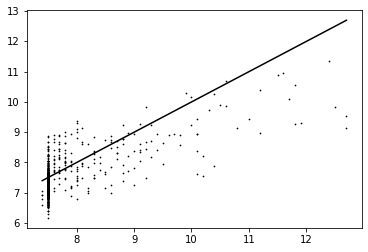

In [111]:
plt.scatter(yshow.flatten(),yshow_predict.flatten(),c='k',s=0.5)
xx = np.linspace(yshow.min(), yshow.max(), 100)
plt.plot(xx,xx, 'k')


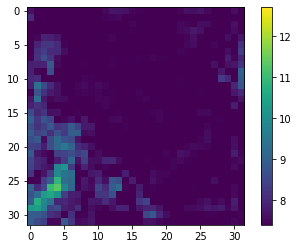

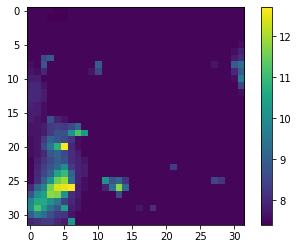

In [113]:
plt.figure()
plt.imshow(yshow_predict, vmin = ymin, vmax = ymax)
plt.colorbar()


plt.figure()
plt.imshow(yshow, vmin = ymin, vmax = ymax)
plt.colorbar()


# plt.figure()
# plt.imshow(yshow_predict,vmin = ymin, vmax = ymax)
# plt.colorbar()
